In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
!pip install matplotlib-venn -q
from matplotlib_venn import venn2
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

## Анализ результатов A/B-тестирования интернет-магазина BitMotion Kit

Заказчик -  интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. Это решение доказуемо повысит количество пользователей, которые совершат покупку.

Задача — провести оценку результатов A/B-теста. В распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Необходимо оценить корректность проведения теста и проанализировать его результаты.

### Цели и задачи исследования



`Цель`: проверить статистическую гипотезу о том, что упрощение интерфейса сайта интернет-магазина BitMotion Kit приводит к увеличению конверсии зарегистрированных пользователей в покупателей как минимум на три процентных пункта в течение семи дней после регистрации.

`Задачи`: загрузить и проверить данные, рассчитать параметры А/В-теста, оценить корректность его проведения и проанализировать результаты.

### Загрузка данных и знакомство с ними


In [2]:
# Выгружаем данные 
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

Познакомимся с данными датафрейма `participants`.

In [3]:
# Выводим первые строки датафрейма participants на экран
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [4]:
# Выводим информацию о датафрейме participants
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [5]:
# Проверяем уникальные значения в столбцах
for column in ['group', 'ab_test', 'device']:
    print(f'Уникальные значения в столбце {column}:')
    print(participants[column].sort_values().unique())
    print()

Уникальные значения в столбце group:
['A' 'B']

Уникальные значения в столбце ab_test:
['interface_eu_test' 'recommender_system_test']

Уникальные значения в столбце device:
['Android' 'Mac' 'PC' 'iPhone']



In [6]:
# Проверяем полные дубликаты в participants
print(f"Полных дубликатов в датафрейме participants: {participants.duplicated().sum()}")

Полных дубликатов в датафрейме participants: 0


**Результаты:**
 - Датасет `participants` содержит 4 столбца и 14525 строк, в которой находятся данные участников тестов.
 - Типы данных заданы верно.
 - Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.
 - Пропусков в данных нет. Все 4 столбца полностью заполнены.
 - Полных дубликатов строк нет.

Познакомимся с данными датафрейма `events`.

In [7]:
# Выводим первые строки датафрейма events на экран
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [8]:
# Выводим информацию о датафрейме events
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


 - Датасет `events` содержит 4 столбца и 787286 строк, в котором собраны события за 2020 года.
 - Типы данных заданы верно.
 - Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.

In [9]:
# Узнаем минимальную и максимальную дату события
events['event_dt'].agg(['min', 'max'])

min   2020-12-01 00:00:00
max   2020-12-31 23:59:48
Name: event_dt, dtype: datetime64[ns]

События пользователей зафиксированы в диапазоне с 1 по 31 декабря 2020 года.

In [10]:
# Проверим уникальные значения в столбцe `event_name`
display(sorted(events['event_name'].unique()))

['End of Black Friday Ads Campaign',
 'Start of CIS New Year Gift Lottery',
 'Start of Christmas&New Year Promo',
 'login',
 'product_cart',
 'product_page',
 'purchase',
 'registration']

In [11]:
# Проверим сколько раз каждое событие встречается в датафрейме events
events['event_name'].value_counts()

event_name
login                                 248285
product_page                          195606
registration                          144183
purchase                              104836
product_cart                           94373
End of Black Friday Ads Campaign           1
Start of Christmas&New Year Promo          1
Start of CIS New Year Gift Lottery         1
Name: count, dtype: int64

Три события (End of Black Friday Ads Campaign, Start of Christmas&New Year Promo, Start of CIS New Year Gift Lottery) встречаются по одному разу. Вероятно, это маркетинговые события, не относящиеся напрямую к поведению пользователей. 

Исключим эти события из анализа A/B-теста, чтобы не искажать статистику.

In [12]:
# Список событий, которые нужно исключить
exclude_events = [
    'End of Black Friday Ads Campaign',
    'Start of Christmas&New Year Promo',
    'Start of CIS New Year Gift Lottery']

# Фильтруем датафрейм, оставляя только нужные события
events = events[~events['event_name'].isin(exclude_events)].reset_index(drop=True)

# Проверяем результат
print("После исключения системных событий осталось строк:", len(events))
print("Уникальные события:", events['event_name'].unique())

После исключения системных событий осталось строк: 787283
Уникальные события: ['registration' 'product_page' 'login' 'product_cart' 'purchase']


Выполним проверку на наличие полных дубликатов записей.

In [13]:
# Проверяем полные дубликаты в events
duplicates_count = events.duplicated().sum()

# Рассчитываем долю дубликатов в процентах
duplicates_share = duplicates_count / len(events) * 100
print(f"Дубликатов: {duplicates_count} ({duplicates_share:.2f}% от всех строк)")

Дубликатов: 36318 (4.61% от всех строк)


Удалим повторы, оставив по одному экземпляру каждой уникальной строки.

In [14]:
# Удаляем повторы
events = events.drop_duplicates().reset_index(drop=True)

# Проверяем размер датафрейма после удаления
print(f"После удаления дубликатов осталось {len(events)} строк.")

После удаления дубликатов осталось 750965 строк.


Определим количество пропусков в датафрейме events.

In [15]:
# Выведем количество пропущенных строк в датафрейме events
display(events.isna().sum())

user_id            0
event_dt           0
event_name         0
details       506063
dtype: int64

In [16]:
# Подсчитаем долю строк с пропусками
print(events.isna().sum() / len(events)) 

user_id       0.000000
event_dt      0.000000
event_name    0.000000
details       0.673884
dtype: float64


В столбце `details` отсутствуют данные в 67% строк, в остальных столбцах пропусков в данных нет. 

Проверим как распределены пропуски в столбце `details` относительно типа события. 

In [17]:
# Создадим признак пропуска
events['is_details'] = events['details'].isna()

# Считаем среднее (True=1, False=0)
events.groupby('event_name')['is_details'].mean()

event_name
login           1.0
product_cart    1.0
product_page    1.0
purchase        0.0
registration    0.0
Name: is_details, dtype: float64

 - Полные пропуски (1.0) наблюдаются только в событиях, связанных с действиями пользователей на сайте — login, product_page, product_cart.
Для этих событий дополнительная информация в столбец details не передавалась.
 - Для событий, связанных с регистрацией и покупками, столбцец details заполнено полностью, что подтверждает корректность данных.
 - Таким образом, пропуски в столбце details не влияют на анализ A/B-теста, так как события registration и purchase содержат все необходимые данные.

Определим сколько уникальных пользователей (user_id) зафиксировано в таблице events.

In [18]:
events['user_id'].nunique()

144184

Проведем анализ распределения количества событий на пользователя.

In [19]:
# Определим основные статистические характеристики распределения активности пользователей
events['user_id'].value_counts().describe()

count    144184.000000
mean          5.208380
std         151.833093
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max       57647.000000
Name: count, dtype: float64

 - В таблице 144184 уникальных пользователей.
 - В среднем на одного пользователя приходится 5 событий (mean = 5.21), медиана — 4 события, что говорит о типичном умеренном уровне активности.
 - Большинство пользователей совершают от 3 до 6 действий (межквартильный размах), что соответствует норме.
 - Максимум — 57 650 событий на пользователя — выглядит как аномалия или тестовый аккаунт, который стоит дополнительно проверить и исключить из анализа, чтобы не исказить статистику теста.
 - Высокое стандартное отклонение (151.84) подтверждает наличие выбросов.

Для исключения влияния аномалий на результаты A/B-теста пользователей с числом событий выше 99-го перцентиля удалим из выборки. После очистки данных в датафрейме останутся только реальные пользователи с нормальной активностью, что обеспечивает корректность дальнейшего анализа.

In [20]:
# Считаем количество событий на пользователя
user_events_count = events['user_id'].value_counts()

# Рассчитываем 99-й перцентиль — верхнюю границу нормальной активности
q99_events = user_events_count.quantile(0.99)
print(f"99-й перцентиль количества событий на пользователя: {q99_events:.0f}")

# Определяем аномально активных пользователей
anomal_users = user_events_count[user_events_count > q99_events].index
print(f"Аномально активных пользователей: {len(anomal_users)}")

# Исключаем аномальных пользователей из данных
events = events[~events['user_id'].isin(anomal_users)].reset_index(drop=True)

# Проверяем размер датафрейма после очистки
print(f"После удаления аномальных пользователей осталось {events['user_id'].nunique()} уникальных пользователей и {len(events)} событий.")


99-й перцентиль количества событий на пользователя: 15
Аномально активных пользователей: 1204
После удаления аномальных пользователей осталось 142980 уникальных пользователей и 671572 событий.


In [21]:
# Выполним проверку
events['user_id'].value_counts().describe()

count    142980.000000
mean          4.696965
std           2.739825
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          15.000000
Name: count, dtype: float64

На данном этапе были выполнены следующие действия:
 - В данных были обнаружены полные дубликаты строк, они удалены, чтобы избежать искажения метрик.
 - События зафиксированы в период с 1 по 31 декабря 2020 года.
 - Количество событий на пользователя сильно варьируется — есть пользователи с крайне высокой активностью, что может указывать на тестовые аккаунты или выбросы. Для исключения влияния аномалий на результаты A/B-теста пользователи с числом событий выше 99-го перцентиля были удалены.
 - В данных присутствовали лишние маркетинговые события (Black Friday, New Year Promo, Gift Lottery) — они были исключены, так как не относятся к тесту.
 - Пропуски встречаются только в незначительных типах событий и не влияют на дальнейший анализ.

В итоге данные очищены и готовы к проведению основного анализа корректности A/B-теста и расчёта конверсии.

### По таблице `participants` оцените корректность проведения теста:

   2.3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

`Изначальное условие`: Интернет-магазин BitMotion Kit провёл A/B-тест (interface_eu_test), чтобы оценить влияние нового, упрощённого интерфейса сайта на поведение пользователей.

`Гипотеза`: упрощение интерфейса увеличит конверсию зарегистрированных пользователей в покупателей в течение 7 дней после регистрации как минимум на 3 процентных пункта по сравнению с контрольной группой.

Определим целевую метрику и сформулируем нулевую и альтернативную гипотезы.

 - Целевая метрика: конверсия зарегистрированных пользователей в покупку в течение 7 дней после регистрации. 
   
 - Нулевая гипотеза: p_a = p_b

Новый интерфейс сайта не влияет на поведение пользователей — конверсия в покупку одинакова в контрольной (A) и тестовой (B) группах.

 - Альтернативная гипотеза: p_a < p_b

Новый интерфейс сайта положительно влияет на поведение пользователей — конверсия в тестовой группе выше, чем в контрольной.

 - Тип гипотезы: Односторонняя

 - Название теста: interface_eu_test

 - Группы: A — контрольная (старый интерфейс), B — тестовая (новый интерфейс).

Данные participants включают результаты двух тестов: interface_eu_test и recommender_system_test. Необходимо определить, пересекаются ли тесты по времени или проходят независимо.

In [22]:
# Получаем даты регистрации пользователей для каждого теста
registration_dates = events[events['event_name'] == 'registration'][['user_id', 'event_dt']]

# Объединяем с participants
participants_dates = participants.merge(registration_dates, on='user_id', how='left')

# Фильтрация по тесту через булеву маску
interface_dates = participants_dates[participants_dates['ab_test'] == 'interface_eu_test']['event_dt']
recommender_dates = participants_dates[participants_dates['ab_test'] == 'recommender_system_test']['event_dt']

# Выводим периоды проведения
print("Период проведения interface_eu_test:", interface_dates.min(), "-", interface_dates.max())
print("Период проведения recommender_system_test:", recommender_dates.min(), "-", recommender_dates.max())

Период проведения interface_eu_test: 2020-12-06 14:10:01 - 2020-12-24 21:57:10
Период проведения recommender_system_test: 2020-12-06 23:59:50 - 2020-12-21 23:45:40


 - Оба теста проводились почти одновременно, начиная с 6 декабря.
 - Пересечение периодов: с 6 по 21 декабря 2020 г. - это означает, что часть пользователей могла участвовать одновременно в обоих тестах.

Для корректного анализа A/B-теста interface_eu_test необходимо исключить пользователей, участвующих в recommender_system_test, чтобы результаты не были искажены влиянием конкурирующего теста.

Определим количество пользователей, участвующих одновременно в двух тестах.

In [23]:
# Разделим пользователей каждого теста
interface_users = set(participants[participants['ab_test'] == 'interface_eu_test']['user_id'])
recommender_users = set(participants[participants['ab_test'] == 'recommender_system_test']['user_id'])

# Находим пересечение пользователей между тестами
intersection_users = interface_users.intersection(recommender_users)
print(f"Количество пользователей, участвующих одновременно в двух тестах: {len(intersection_users)}")

Количество пользователей, участвующих одновременно в двух тестах: 887


Визуализируем пересечение пользователей с помощью диаграммы Венна.

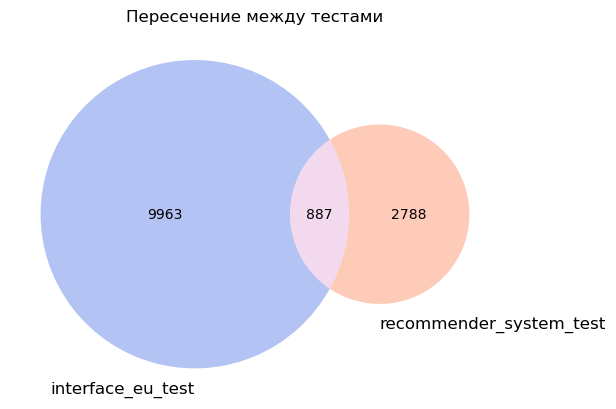

In [24]:
first_id = set(participants[participants['ab_test'] == 'interface_eu_test']['user_id'])
second_id = set(participants[participants['ab_test'] == 'recommender_system_test']['user_id'])
# Строим диаграмму Венна
venn2([first_id, second_id], set_labels=('interface_eu_test', 'recommender_system_test'), set_colors=('royalblue', 'coral'))

# Отображаем график
plt.title("Пересечение между тестами")
plt.show()

Исключим этих пользователей из датафреймов `participants` и `events`.

In [25]:
# Исключаем из participants
participants = participants[~participants['user_id'].isin(intersection_users)].reset_index(drop=True)

# Исключаем из events
events = events[~events['user_id'].isin(intersection_users)].reset_index(drop=True)

# Проверяем результаты
print(f"После удаления пересекающихся пользователей осталось {participants['user_id'].nunique()} участников теста.")
print(f"После удаления пересекающихся пользователей осталось {events['user_id'].nunique()} уникальных пользователей в событиях.")

После удаления пересекающихся пользователей осталось 12751 участников теста.
После удаления пересекающихся пользователей осталось 142099 уникальных пользователей в событиях.


Далее в датафрейме participants оставим только участников нужного A/B-теста - `'interface_eu_test'`.

In [26]:
# Оставляем только участников нужного теста
participants_interface = participants[participants['ab_test'] == 'interface_eu_test'].copy()
print(f"После удаления пересекающихся пользователей и участников параллельного теста осталось {participants_interface['user_id'].nunique()} участников теста 'interface_eu_test'.")

После удаления пересекающихся пользователей и участников параллельного теста осталось 9963 участников теста 'interface_eu_test'.


Разделим пользователей на группы и проверим, отсутствуют ли пересечения между ними.

In [27]:
# Разделим пользователей по группам
users_group_a = set(participants_interface.loc[participants_interface['group'] == 'A', 'user_id'])
users_group_b = set(participants_interface.loc[participants_interface['group'] == 'B', 'user_id'])

In [28]:
# Найдём пересечение пользователей, попавших в обе группы
overlap_users = users_group_a.intersection(users_group_b)

In [29]:
# Выводим результаты
if len(overlap_users) == 0:
    print("Группы независимы: пересечений пользователей нет.")
else:
    print(f"Найдено {len(overlap_users)} пользователей, попавших одновременно в группы A и B.")

Группы независимы: пересечений пользователей нет.


Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп и на основе этих данных построим столбчатую диаграмму.

In [30]:
# Считаем количество уникальных пользователей в каждой группе
users_per_group = participants_interface.groupby('group')['user_id'].nunique().reset_index().rename(columns={'user_id': 'unique_users'})

In [31]:
# Вывод на экран
print("Количество уникальных пользователей в каждой группе:")
display(users_per_group)

Количество уникальных пользователей в каждой группе:


,group,unique_users
0,A,4952
1,B,5011


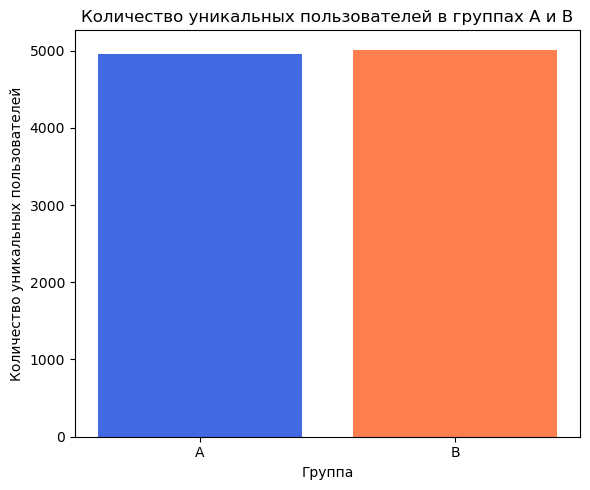

In [32]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(6, 5))

# Строим стобчатую диаграмму
plt.bar(users_per_group['group'], users_per_group['unique_users'], color=['royalblue', 'coral'])

# Настраиваем оформление графика
plt.title('Количество уникальных пользователей в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')

# Выводим график
plt.tight_layout()
plt.show()

Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B.

In [33]:
# Рассчитываем процентную разницу между группами
a_users = users_per_group.loc[users_per_group['group'] == 'A', 'unique_users'].values[0]
b_users = users_per_group.loc[users_per_group['group'] == 'B', 'unique_users'].values[0]

percent_diff = round(100 * (abs(a_users - b_users) / a_users),2)

print(f"Процентная разница между группами A и B составляет {percent_diff}%")

Процентная разница между группами A и B составляет 1.19%


Разница в численности пользователей между группами A и B составляет менее 1.2%, что **указывает на их равномерное распределение**.

Дополнительно проверим, что пользователи равномерно распределены по типам устройств.

Выполним группировку данных по группе и типу устройства с расчётом числа уникальных пользователей в каждой категории.

In [34]:
# Группируем данные по типу устройства и группе теста
device_dist = participants_interface.groupby(['group', 'device'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})

In [35]:
# Добавляем столбец с процентом пользователей по каждому устройству в пределах группы
device_dist['percent'] = round(device_dist['users'] / device_dist.groupby('group')['users'].transform('sum') * 100,2)

In [36]:
# Вывод на экран
display(device_dist)

,group,device,users,percent
0,A,Android,2264,45.72
1,A,Mac,515,10.40
2,A,PC,1223,24.70
3,A,iPhone,950,19.18
4,B,Android,2218,44.26
5,B,Mac,511,10.20
6,B,PC,1302,25.98
7,B,iPhone,980,19.56


Построим две диаграммы:
- доля каждого типа устройства для пользователей из группы A,
- доля каждого типа устройства для пользователей из группы B.

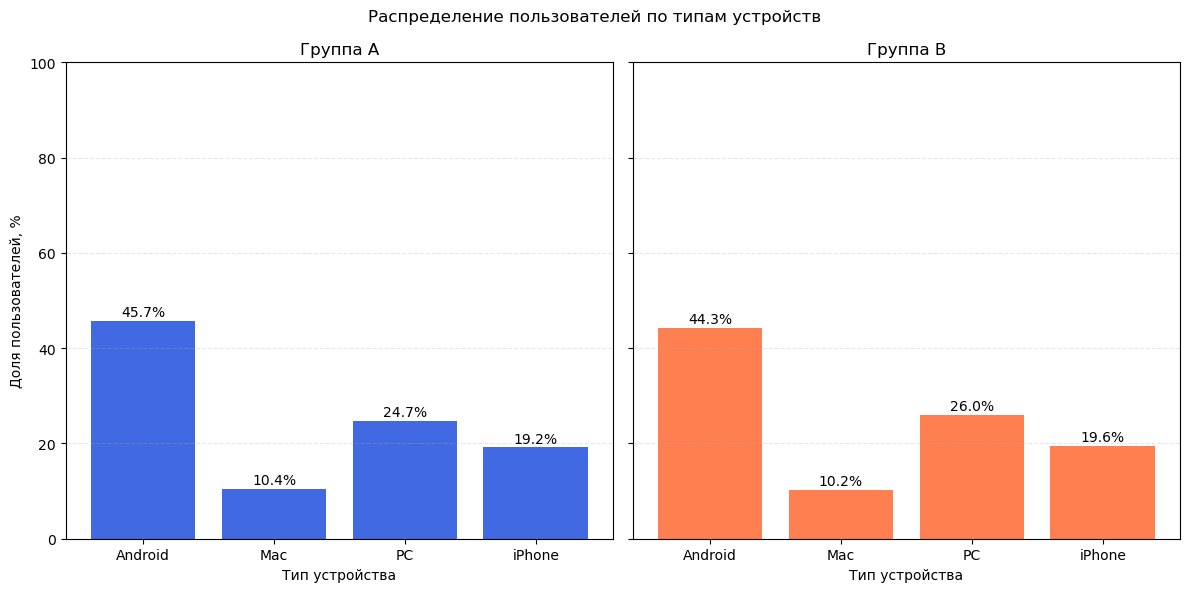

In [37]:
# Разделяем данные по группам A и B
device_a = device_dist[device_dist['group'] == 'A']
device_b = device_dist[device_dist['group'] == 'B']

# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Строим диаграмму (группа A)
axes[0].bar(device_a['device'], device_a['percent'], color='royalblue')

# Настраиваем оформление графика (группа A)
axes[0].set_title('Группа A')
axes[0].set_xlabel('Тип устройства')
axes[0].set_ylabel('Доля пользователей, %')
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(device_a['percent']):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# Строим диаграмму
axes[1].bar(device_b['device'], device_b['percent'], color='coral')

# Настраиваем оформление графика (группа B)
axes[1].set_title('Группа B')
axes[1].set_xlabel('Тип устройства')
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(device_b['percent']):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# Настраиваем оформление графика
plt.suptitle('Распределение пользователей по типам устройств')

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Распределение пользователей по группам и типам устройств является равномерным - доли пользователей на каждой платформе практически совпадают между группами A и B (разница по долям не превышает 1–2%).
 - Основная часть пользователей приложения использует Android (45%).

2.3\.2 Проанализируем данные о пользовательской активности по таблице `events`.

Оставим только те события в датафрейме events, которые связаны с участвующими в  тесте 'interface_eu_test' пользователями.

In [38]:
# Отфильтруем события, оставляя только пользователей теста interface_eu_test
events = events[events['user_id'].isin(interface_users)].reset_index(drop=True)

# Проверим результат
print(f"В таблице 'events' находится {events['user_id'].nunique()} уникальных пользователей и {len(events)} событий, относящихся к тесту 'interface_eu_test'.")

В таблице 'events' находится 9774 уникальных пользователей и 64677 событий, относящихся к тесту 'interface_eu_test'.


В таблице events оставлены только события пользователей, участвующих в A/B-тесте interface_eu_test.
Это гарантирует, что последующий анализ будет основан исключительно на данных эксперимента и не будет искажён внешними факторами.

Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации.

In [39]:
# Найдем даты регистрации пользователей
registration = events[events['event_name'] == 'registration'][['user_id', 'event_dt']].rename(columns={'event_dt': 'registration_dt'})

# Добавим дату регистрации каждому пользователю
events = events.merge(registration, on='user_id', how='left')

# Рассчитаем время (лайфтайм) между регистрацией и каждым событием
events['lifetime'] = (events['event_dt'] - events['registration_dt']).dt.total_seconds() / (24 * 60 * 60)

# Оставим только события, совершённые в течение 7 дней после регистрации
events = events[events['lifetime'].between(0, 7)].reset_index(drop=True)

# Проверим результат
print(f"В таблице 'events' осталось {len(events)} событий от {events['user_id'].nunique()} пользователей, совершённых в течение первых 7 дней после регистрации.")


В таблице 'events' осталось 56205 событий от 9774 пользователей, совершённых в течение первых 7 дней после регистрации.


В таблице 'events' оставлены только события, совершённые в течение первых 7 дней после регистрации, поскольку именно этот период рассматривается в гипотезе A/B-теста.

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:
- базовый показатель конверсии — 30%
- мощность теста — 80%
- достоверность теста — 95%

In [40]:
# Задаем параметры
p1 = 0.30  # базовая конверсия (группа A)
p2 = 0.33  # ожидаемая конверсия (группа B)
alpha = 0.05  # уровень значимости (95% доверие)
power = 0.8   # мощность теста (80%)
effect_size = proportion_effectsize(p1, p2)

# Инициализируем класс NormalIndPower
analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)

print(f"Минимально необходимый размер выборки на группу: {round(sample_size)} пользователей")
print(f"Итого для двух групп: {round(sample_size * 2)} пользователей")


Минимально необходимый размер выборки на группу: 3762 пользователей
Итого для двух групп: 7523 пользователей


Фактическое число пользователей в группах A и B превышает рассчитанный минимум, а значит тест можно считать достаточно мощным для выявления изменения конверсии на 3 процентных пункта.

Рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [41]:
# Общее количество уникальных пользователей в каждой группе
total_users = participants_interface.groupby('group')['user_id'].nunique()

# Оставим только события с покупками
purchase_events = events[events['event_name'] == 'purchase']

# Добавим к ним информацию о группе из таблицы participants_interface
purchase_with_groups = purchase_events.merge(participants_interface[['user_id', 'group']],on='user_id',how='inner')

# Посчитаем количество уникальных пользователей, совершивших покупку, по каждой группе
purchase_users = purchase_with_groups.groupby('group')['user_id'].nunique()

# Объединим результаты в одну таблицу
conversion_data = pd.DataFrame({
    'total_users': total_users,
    'purchase_users': purchase_users})

# Рассчитаем конверсию в процентах
conversion_data['conversion_rate'] = round(conversion_data['purchase_users'] / conversion_data['total_users'] * 100,2)

# Вывод на экран
display(conversion_data)

,total_users,purchase_users,conversion_rate
group,,,
A,4952,1333,26.92
B,5011,1388,27.70


По результатам предварительного анализа видно, что в тестовой группе B, где пользователям был предложен новый упрощённый интерфейс сайта, доля пользователей, совершивших покупку, оказалась немного выше, чем в контрольной группе A с исходным дизайном.

 - В контрольной группе (A) конверсия в покупку составила 26.9%,
 - В тестовой группе (B) конверсия в покупку составила 27.7%, что соответствует приросту примерно на 0.8 процентных пункта.

Это может свидетельствовать о том, что обновлённый интерфейс позитивно влияет на вовлечённость пользователей и их склонность к совершению покупки.

Однако наблюдаемое различие является незначительным и не позволяет с уверенностью утверждать о статистически значимом эффекте. Для подтверждения или опровержения гипотезы требуется дополнительный статистический анализ — проведение z-теста для пропорций.

### Проведите оценку результатов A/B-тестирования:

`Гипотеза`: упрощение интерфейса увеличит конверсию зарегистрированных пользователей в покупателей в течение 7 дней после регистрации как минимум на 3 процентных пункта по сравнению с контрольной группой.

 - Целевая метрика: конверсия зарегистрированных пользователей в покупку в течение 7 дней после регистрации. 
 
 - Нулевая гипотеза: p_a = p_b

Новый интерфейс сайта не влияет на поведение пользователей — конверсия в покупку одинакова в контрольной (A) и тестовой (B) группах.

 - Альтернативная гипотеза: p_a < p_b

Новый интерфейс сайта положительно влияет на поведение пользователей — конверсия в тестовой группе выше, чем в контрольной.

 - Тип гипотезы: Односторонняя

 - Название теста: interface_eu_test

 - Группы: A — контрольная (старый интерфейс), B — тестовая (новый интерфейс).

Проверим изменение конверсии с помощью z-теста пропорций.

In [42]:
# Применяем z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest(count=conversion_data['purchase_users'], nobs=conversion_data['total_users'], alternative='smaller')

print(f"p-value: {p_value_ztest:.4f}")

p-value: 0.1910


In [43]:
# Интерпретация результата
if p_value_ztest > alpha:
    print("Разница статистически незначима: пока нет оснований утверждать, что новый алгоритм улучшил метрику.")
else:
    print("Разница статистически значима: новый алгоритм повышает долю успешных сессий.")

Разница статистически незначима: пока нет оснований утверждать, что новый алгоритм улучшил метрику.


По результатам z-теста пропорций новый интерфейс сайта демонстрирует незначительный рост конверсии в покупку, однако различие статистически незначимо (p-value = 0.1910>0.05). На основании текущих данных нет достаточных оснований утверждать, что упрощённый интерфейс реально улучшает поведение пользователей.

**Вывод:**

По результатам A/B-теста interface_eu_test, конверсия в тестовой группе (B) оказалась выше, чем в контрольной (A), однако различие **не достигло статистической значимости** (p-value = 0.1910 > 0.05).
Это означает, что при текущем размере выборки и уровне значимости нельзя с уверенностью утверждать, что новый интерфейс действительно повышает конверсию.
Возможные причины — недостаточная мощность теста, слишком короткий период наблюдения или малый эффект изменения.

**Рекомендации:**

 - Увеличить размер выборки и повторить эксперимент.

 - Проанализировать дополнительные метрики (глубина просмотра, добавления в корзину, время на сайте).